In [49]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
import os
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import RF_regressor, plot_importances, encode_tulabel
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.utils.directories import get_parent_directory
from src.visualisation.visual_predictions import plot_predictions

In [50]:
parent_dir = get_parent_directory()

## IPY Barneo 2008

In [53]:
# Specify the path and filename for the pickle file
#pickle_path_RF = os.path.join(parent_dir, "models/RandomForest/TEA-COSI_testdf.pkl")
#RF_testdf = pd.read_pickle(pickle_path_RF)

# Specify the path and filename for the pickle file
pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost/Mosaic_testdf.pkl")
# Pickle the DataFrame
XGB_testdf = pd.read_pickle(pickle_path_XGB)

# Specify the path and filename for the pickle file
# pickle_path_global = os.path.join(parent_dir, "models/XG_global/Barneo2008_testdf.pkl")
# Pickle the DataFrame
# global_testdf = pd.read_pickle(pickle_path_global)

## Performance metrics

In [4]:
from src.models.corr_func import score_metrics

In [ ]:
# ACSOS
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

In [43]:
# ACSOS
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -0.0223
Mean Error (ME): -0.0181
Mean Absolute Error (MAE): 0.1722
Residual Standard Deviation: 0.2835


In [40]:
# ABSO
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -0.1312
Mean Error (ME): -0.4484
Mean Absolute Error (MAE): 0.4867
Residual Standard Deviation: 0.6584


In [45]:
# Barneo2007
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: 0.2427
Mean Error (ME): 0.0328
Mean Absolute Error (MAE): 0.2135
Residual Standard Deviation: 0.3021


In [37]:
# NICE-2015
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -0.7171
Mean Error (ME): -0.3418
Mean Absolute Error (MAE): 0.4647
Residual Standard Deviation: 0.4521


In [54]:
# Mosaic
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: 0.3255
Mean Error (ME): 0.0584
Mean Absolute Error (MAE): 0.2788
Residual Standard Deviation: 0.4241


In [33]:
# Nansen2019
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -0.6249
Mean Error (ME): 0.6698
Mean Absolute Error (MAE): 0.7136
Residual Standard Deviation: 0.4204


In [25]:
# Nansen2018
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -0.1645
Mean Error (ME): 0.4487
Mean Absolute Error (MAE): 0.6288
Residual Standard Deviation: 0.5741


In [48]:
# ArcticMix
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -1.8679
Mean Error (ME): 2.0923
Mean Absolute Error (MAE): 2.3234
Residual Standard Deviation: 1.3111


In [52]:
# TEA-COSI
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -7.8301
Mean Error (ME): -1.4372
Mean Absolute Error (MAE): 1.5955
Residual Standard Deviation: 1.3658


In [15]:
log_eps_df = pd.DataFrame(RF_testdf["log_eps"])
pred_eps_df = pd.DataFrame(RF_testdf["eps_pred"])
score_metrics(log_eps_df, RF_testdf["eps_pred"])

R2 Score: -1.0650
Mean Error (ME): 0.0696
Mean Absolute Error (MAE): 0.3034
Residual Standard Deviation: 0.5045


In [16]:
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: 0.2406
Mean Error (ME): -0.0068
Mean Absolute Error (MAE): 0.2090
Residual Standard Deviation: 0.3249


sorted_df_XGB_7 = XGB_7_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB_7 = sorted_df_XGB_7[sorted_df_XGB_7['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost 7 features epsilon predictions
    mean_df_XGB_7 = sampled_df_XGB_7.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost 7 features
    std_dev_XGB_7 = mean_df_XGB_7['eps_pred'].std()
    ci_lower_XGB_7 = mean_df_XGB_7['eps_pred'] - std_dev_XGB_7  # Lower bound of the confidence interval
    ci_upper_XGB_7 = mean_df_XGB_7['eps_pred'] + std_dev_XGB_7  # Upper bound of the confidence interval




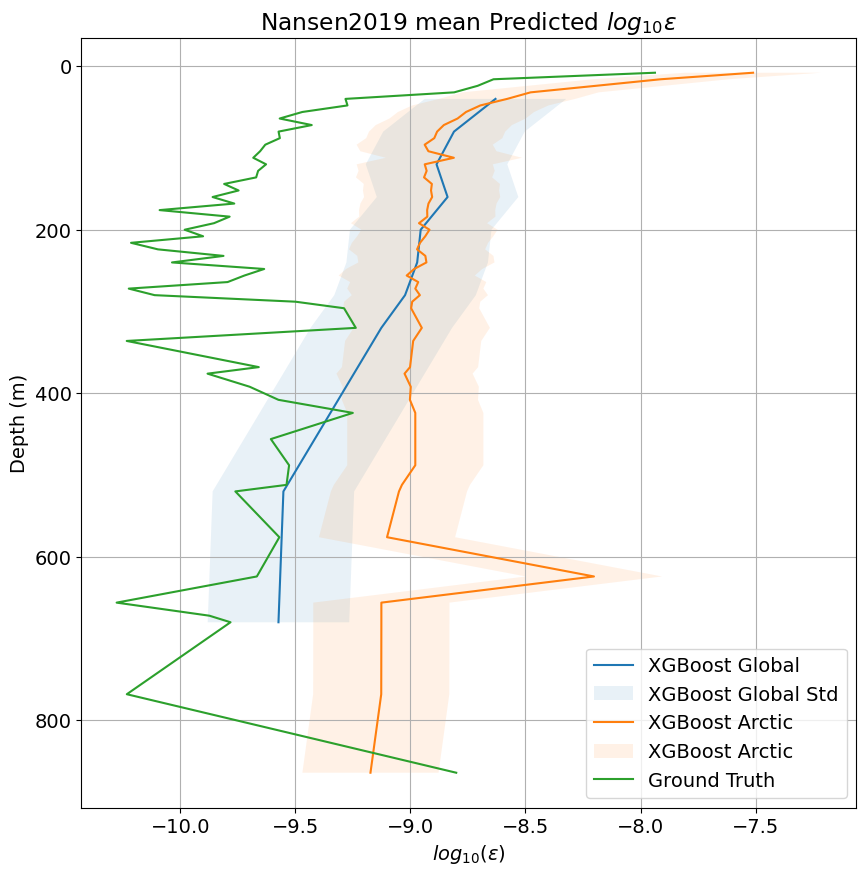

In [68]:
plot_predictions("Nansen2019", parent_dir)

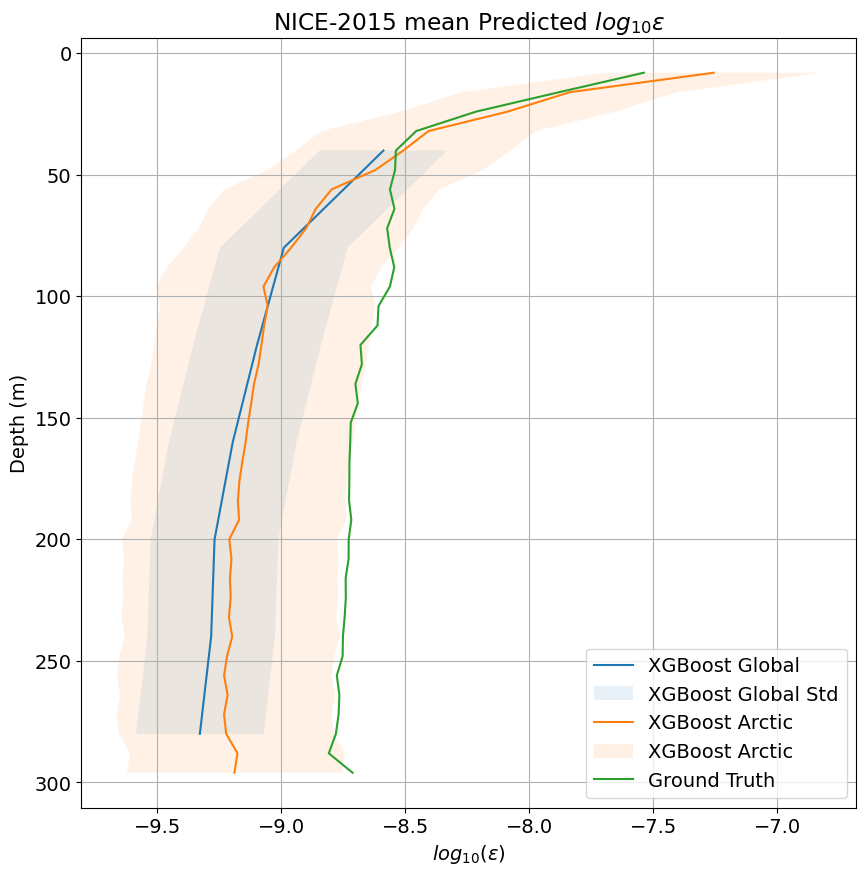

In [67]:
plot_predictions("NICE-2015", parent_dir)

In [66]:

def plot_predictions(cruise, parent_dir):
    """
    Plots the mean predicted epsilon values along with the ground truth
    epsilon values for different models (Random Forest, XGBoost, and XGBoost
    7 features) as a function of depth.

    Parameters:
        cruise (str): The name of the cruise.
        parent_dir (str): The parent directory where the pickle files are located.

    Returns:
        None

    Example:
        plot_predictions("cruise1", "/path/to/parent_dir")
    """
    # Specify the path and filename for the pickle file
    cruise_file = cruise + "_testdf.pkl"
    #pickle_path_RF = os.path.join(parent_dir, "models/RandomForest", cruise_file)
    #RF_testdf = pd.read_pickle(pickle_path_RF)

    # Specify the path and filename for the pickle file
    pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost", cruise_file)
    XGB_testdf = pd.read_pickle(pickle_path_XGB)

    # Specify the path and filename for the pickle file
    pickle_path_XGB_g = os.path.join(parent_dir, "models/XGBoost_global", cruise_file)
    XGB_g_testdf = pd.read_pickle(pickle_path_XGB_g)
    
    # Specify the path and filename for the pickle file
    pickle_path_XGB_7 = os.path.join(parent_dir, "models/XGBoost_global", cruise_file)
    XGB_7_testdf = pd.read_pickle(pickle_path_XGB_7)
    
    # Specify the path and filename for the pickle file
    #pickle_path_RMLP = os.path.join(parent_dir, "models/ResMLP", cruise_file)
    #RMLP_testdf = pd.read_pickle(pickle_path_RMLP)

    sorted_df_XGB = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB = sorted_df_XGB[sorted_df_XGB['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB = sampled_df_XGB.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB = mean_df_XGB['eps_pred'].std()
    ci_lower_XGB = mean_df_XGB['eps_pred'] - std_dev_XGB  # Lower bound of the confidence interval
    ci_upper_XGB = mean_df_XGB['eps_pred'] + std_dev_XGB  # Upper bound of the confidence interval

    sorted_df_XGB_g = XGB_g_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB_g = sorted_df_XGB_g[sorted_df_XGB_g['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB_g = sampled_df_XGB_g.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB_g = mean_df_XGB_g['eps_pred'].std()
    ci_lower_XGB_g = mean_df_XGB_g['eps_pred'] - std_dev_XGB_g  # Lower bound of the confidence interval
    ci_upper_XGB_g = mean_df_XGB_g['eps_pred'] + std_dev_XGB_g  # Upper bound of the confidence interval
    
    sorted_df_XGB_7 = XGB_7_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB_7 = sorted_df_XGB_7[sorted_df_XGB_7['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB_7 = sampled_df_XGB_7.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB_7 = mean_df_XGB_7['eps_pred'].std()
    ci_lower_XGB_7 = mean_df_XGB_7['eps_pred'] - std_dev_XGB_7  # Lower bound of the confidence interval
    ci_upper_XGB_7 = mean_df_XGB_7['eps_pred'] + std_dev_XGB_7  # Upper bound of the confidence interval
    
    #sorted_df_RMLP = RMLP_testdf.sort_values('depth')
    # Sample every 10 meters
    #sampled_df_RMLP = sorted_df_RMLP[sorted_df_RMLP['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    #mean_df_RMLP = sampled_df_RMLP.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    #std_dev_RMLP = mean_df_RMLP['eps_pred'].std()
    #
    # ci_upper_RMLP = mean_df_RMLP['eps_pred'] + std_dev_RMLP # Upper bound of the confidence interval
    
    #sorted_df_RF = RF_testdf.sort_values('depth')
    # Sample every 10 meters
    #sampled_df_RF = sorted_df_RF[sorted_df_RF['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of epsilon predictions
    #mean_df_RF = sampled_df_RF.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation
    #std_dev_RF = mean_df_RF['eps_pred'].std()
    #ci_lower_RF = mean_df_RF['eps_pred'] - std_dev_RF  # Lower bound of the confidence interval
   #ci_upper_RF = mean_df_RF['eps_pred'] + std_dev_RF  # Upper bound of the confidence interval
    
    sorted_df_GT = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_GT = sorted_df_GT[sorted_df_GT['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_GT = sampled_df_GT.groupby('depth')['log_eps'].mean().reset_index()
    
    #plt.plot(mean_df_RF['eps_pred'], mean_df_RF['depth'], label='RandomForest')
    #plt.fill_betweenx(mean_df_RF['depth'], ci_lower_RF, ci_upper_RF, alpha=0.1, label='Random Forest Std')

    #plt.plot(mean_df_RMLP['eps_pred'], mean_df_RMLP['depth'], label='ResMLP Global')
    #plt.fill_betweenx(mean_df_RMLP['depth'], ci_lower_RMLP, ci_upper_RMLP, alpha=0.1, label='ResMLP Global Std')
    
    plt.plot(mean_df_XGB_g['eps_pred'], mean_df_XGB_g['depth'], label='XGBoost Global')
    plt.fill_betweenx(mean_df_XGB_g['depth'], ci_lower_XGB_g, ci_upper_XGB_g, alpha=0.1, label='XGBoost Global Std')

    #plt.plot(mean_df_XGB_7['eps_pred'], mean_df_XGB_7 ['depth'], label='XGBoost 7')
    #plt.fill_betweenx(mean_df_XGB_7 ['depth'], ci_lower_XGB_7, ci_upper_XGB_7, alpha=0.1, label='XGBoost 7 std')

    plt.plot(mean_df_XGB['eps_pred'], mean_df_XGB['depth'], label='XGBoost Arctic')
    plt.fill_betweenx(mean_df_XGB['depth'], ci_lower_XGB, ci_upper_XGB, alpha=0.1, label='XGBoost Arctic')
    
    plt.plot(mean_df_GT['log_eps'], mean_df_GT['depth'], label='Ground Truth')

    plt.xlabel('$log_{10}(\epsilon)$')
    plt.ylabel('Depth (m)')
    plt.title(cruise + ' mean Predicted $log_{10} \epsilon$')
    plt.grid(True)
    plt.legend()

    plt.gca().invert_yaxis()  # Invert the y-axis

    plt.show()


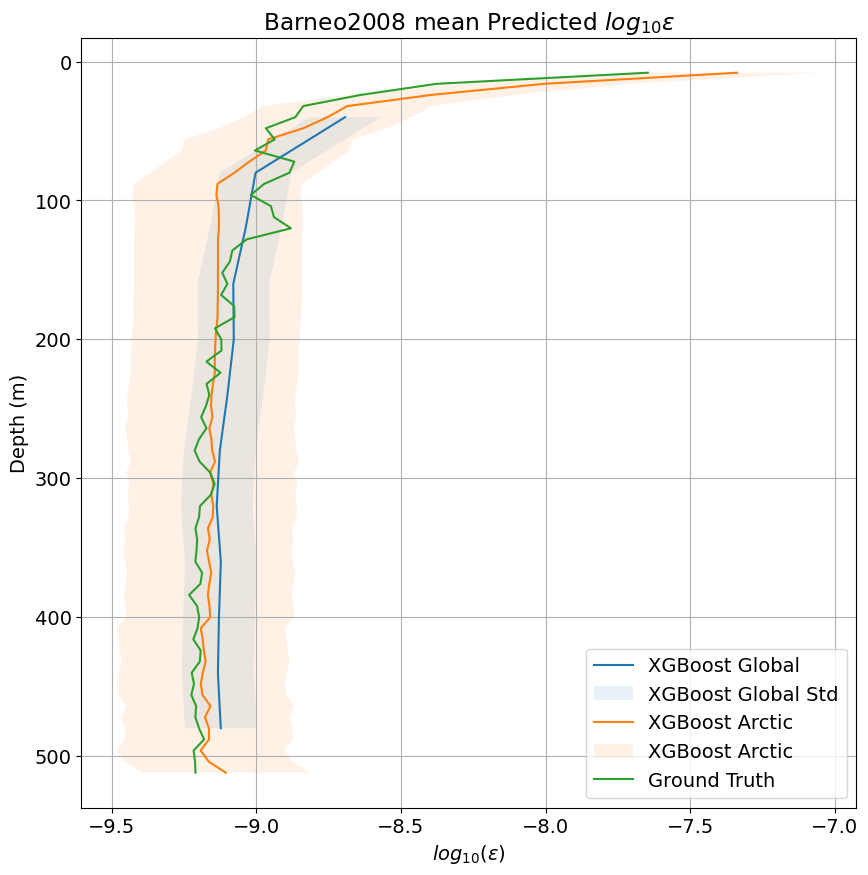

In [46]:
plot_predictions("Barneo2008", parent_dir)

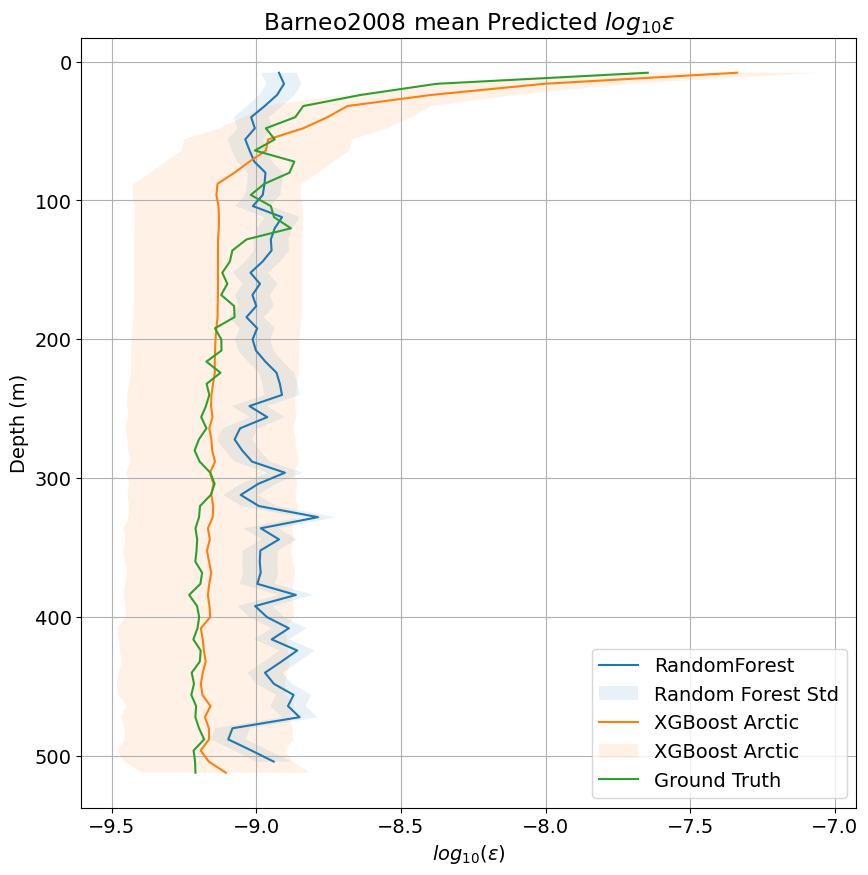

In [15]:
plot_predictions("Barneo2008", parent_dir)

# ArcticMix plots

In [40]:

def plot_predictions(cruise, parent_dir):
    """
    Plots the mean predicted epsilon values along with the ground truth
    epsilon values for different models (Random Forest, XGBoost, and XGBoost
    7 features) as a function of depth.

    Parameters:
        cruise (str): The name of the cruise.
        parent_dir (str): The parent directory where the pickle files are located.

    Returns:
        None

    Example:
        plot_predictions("cruise1", "/path/to/parent_dir")
    """
    # Specify the path and filename for the pickle file
    cruise_file = cruise + "_testdf.pkl"
    pickle_path_RF = os.path.join(parent_dir, "models/RandomForest", cruise_file)
    RF_testdf = pd.read_pickle(pickle_path_RF)

    # Specify the path and filename for the pickle file
    pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost", cruise_file)
    XGB_testdf = pd.read_pickle(pickle_path_XGB)

    # Specify the path and filename for the pickle file
    pickle_path_XGB_g = os.path.join(parent_dir, "models/XGBoost_global", cruise_file)
    XGB_g_testdf = pd.read_pickle(pickle_path_XGB_g)

    sorted_df_XGB = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB = sorted_df_XGB[sorted_df_XGB['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB = sampled_df_XGB.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB = mean_df_XGB['eps_pred'].std()
    ci_lower_XGB = mean_df_XGB['eps_pred'] - std_dev_XGB  # Lower bound of the confidence interval
    ci_upper_XGB = mean_df_XGB['eps_pred'] + std_dev_XGB  # Upper bound of the confidence interval

    sorted_df_XGB_g = XGB_g_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB_g = sorted_df_XGB_g[sorted_df_XGB_g['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB_g = sampled_df_XGB_g.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB_g = mean_df_XGB_g['eps_pred'].std()
    ci_lower_XGB_g = mean_df_XGB_g['eps_pred'] - std_dev_XGB_g  # Lower bound of the confidence interval
    ci_upper_XGB_g = mean_df_XGB_g['eps_pred'] + std_dev_XGB_g  # Upper bound of the confidence interval
    
    sorted_df_RF = RF_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_RF = sorted_df_RF[sorted_df_RF['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of epsilon predictions
    mean_df_RF = sampled_df_RF.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation
    std_dev_RF = mean_df_RF['eps_pred'].std()
    ci_lower_RF = mean_df_RF['eps_pred'] - std_dev_RF  # Lower bound of the confidence interval
    ci_upper_RF = mean_df_RF['eps_pred'] + std_dev_RF  # Upper bound of the confidence interval
    
    sorted_df_GT = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_GT = sorted_df_GT[sorted_df_GT['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_GT = sampled_df_GT.groupby('depth')['log_eps'].mean().reset_index()
    
    #plt.plot(mean_df_RF['eps_pred'], mean_df_RF['depth'], label='RandomForest')
    #plt.fill_betweenx(mean_df_RF['depth'], ci_lower_RF, ci_upper_RF, alpha=0.1, label='Random Forest Std')

    plt.plot(mean_df_XGB_g['eps_pred'], mean_df_XGB_g['depth'], label='XGBoost Global')
    plt.fill_betweenx(mean_df_XGB_g['depth'], ci_lower_XGB_g, ci_upper_XGB_g, alpha=0.1, label='XGBoost Global Std')

    plt.plot(mean_df_XGB['eps_pred'], mean_df_XGB['depth'], label='XGBoost Arctic')
    plt.fill_betweenx(mean_df_XGB['depth'], ci_lower_XGB, ci_upper_XGB, alpha=0.1, label='XGBoost Arctic')
    
    plt.plot(mean_df_GT['log_eps'], mean_df_GT['depth'], label='Ground Truth')

    plt.xlabel('$log_{10}(\epsilon)$')
    plt.ylabel('Depth (m)')
    plt.title(cruise + ' mean Predicted $log_{10} \epsilon$')
    plt.grid(True)
    plt.legend()

    plt.gca().invert_yaxis()  # Invert the y-axis

    plt.show()


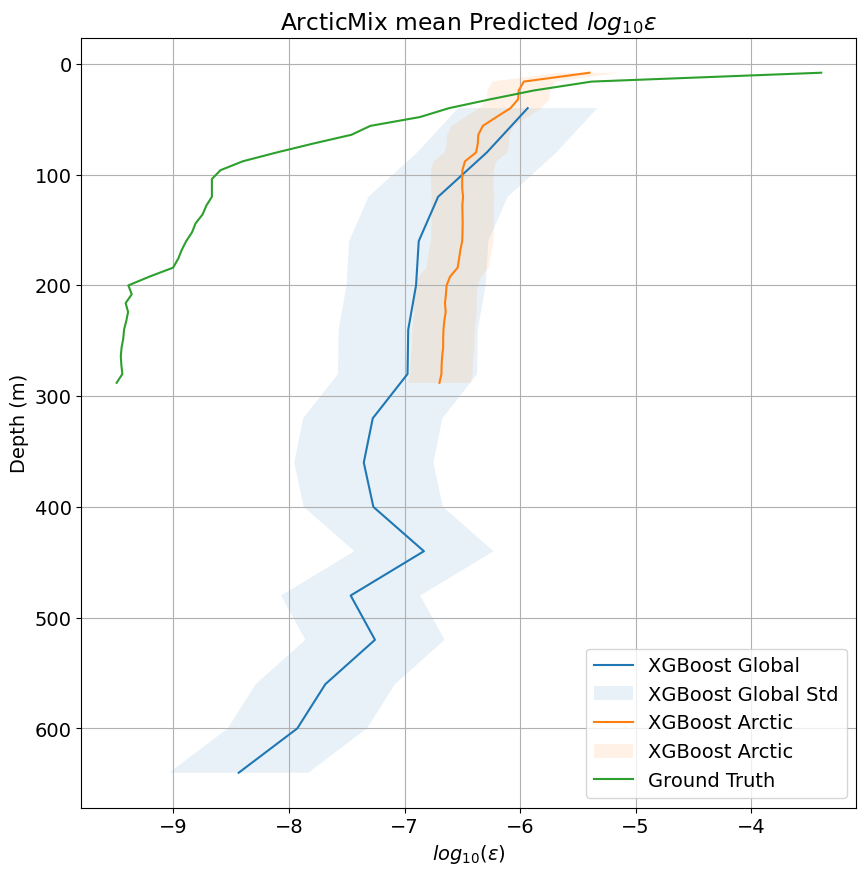

In [41]:
plot_predictions("ArcticMix", parent_dir)

## TEA-COSI plots

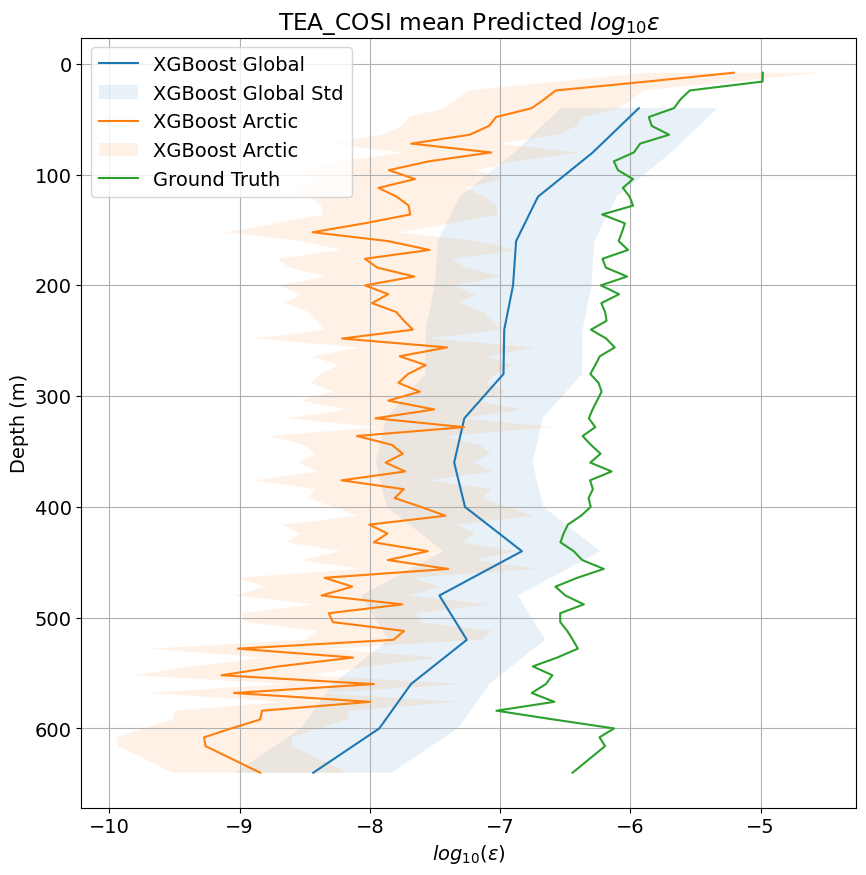

In [19]:
# global -6.4
# XGBoost -5.4
# RandomForest -9.95
plot_predictions("TEA_COSI", parent_dir)

# Cruise 14

In [28]:

def plot_predictions(cruise, parent_dir):
    """
    Plots the mean predicted epsilon values along with the ground truth
    epsilon values for different models (Random Forest, XGBoost, and XGBoost
    7 features) as a function of depth.

    Parameters:
        cruise (str): The name of the cruise.
        parent_dir (str): The parent directory where the pickle files are located.

    Returns:
        None

    Example:
        plot_predictions("cruise1", "/path/to/parent_dir")
    """
    # Specify the path and filename for the pickle file
    cruise_file = "14" + "_testdf.pkl"
    #pickle_path_RF = os.path.join(parent_dir, "models/RandomForest", cruise_file)
    #RF_testdf = pd.read_pickle(pickle_path_RF)

    # Specify the path and filename for the pickle file
    #pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost", cruise_file)
    #XGB_testdf = pd.read_pickle(pickle_path_XGB)

    # Specify the path and filename for the pickle file
    pickle_path_XGB_g = os.path.join(parent_dir, "models/XGBoost_global", cruise_file)
    XGB_g_testdf = pd.read_pickle(pickle_path_XGB_g)

    sorted_df_XGB_g = XGB_g_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB_g = sorted_df_XGB_g[sorted_df_XGB_g['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB_g = sampled_df_XGB_g.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB_g = mean_df_XGB_g['eps_pred'].std()
    ci_lower_XGB_g = mean_df_XGB_g['eps_pred'] - std_dev_XGB_g  # Lower bound of the confidence interval
    ci_upper_XGB_g = mean_df_XGB_g['eps_pred'] + std_dev_XGB_g  # Upper bound of the confidence interval

    sorted_df_GT = XGB_g_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_GT = sorted_df_GT[sorted_df_GT['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_GT = sampled_df_GT.groupby('depth')['log_eps'].mean().reset_index()
    
    #plt.plot(mean_df_RF['eps_pred'], mean_df_RF['depth'], label='RandomForest')
    #plt.fill_betweenx(mean_df_RF['depth'], ci_lower_RF, ci_upper_RF, alpha=0.1, label='Random Forest Std')

    plt.plot(mean_df_XGB_g['eps_pred'], mean_df_XGB_g['depth'], label='XGBoost Global')
    plt.fill_betweenx(mean_df_XGB_g['depth'], ci_lower_XGB_g, ci_upper_XGB_g, alpha=0.1, label='XGBoost Global Std')

    #plt.plot(mean_df_XGB['eps_pred'], mean_df_XGB['depth'], label='XGBoost Arctic')
    #plt.fill_betweenx(mean_df_XGB['depth'], ci_lower_XGB, ci_upper_XGB, alpha=0.1, label='XGBoost Arctic')
    
    plt.plot(mean_df_GT['log_eps'], mean_df_GT['depth'], label='Ground Truth')

    plt.xlabel('$log_{10}(\epsilon)$')
    plt.ylabel('Depth (m)')
    plt.title("14"+ ' mean Predicted $log_{10} \epsilon$')
    plt.grid(True)
    plt.legend()

    plt.gca().invert_yaxis()  # Invert the y-axis

    plt.show()


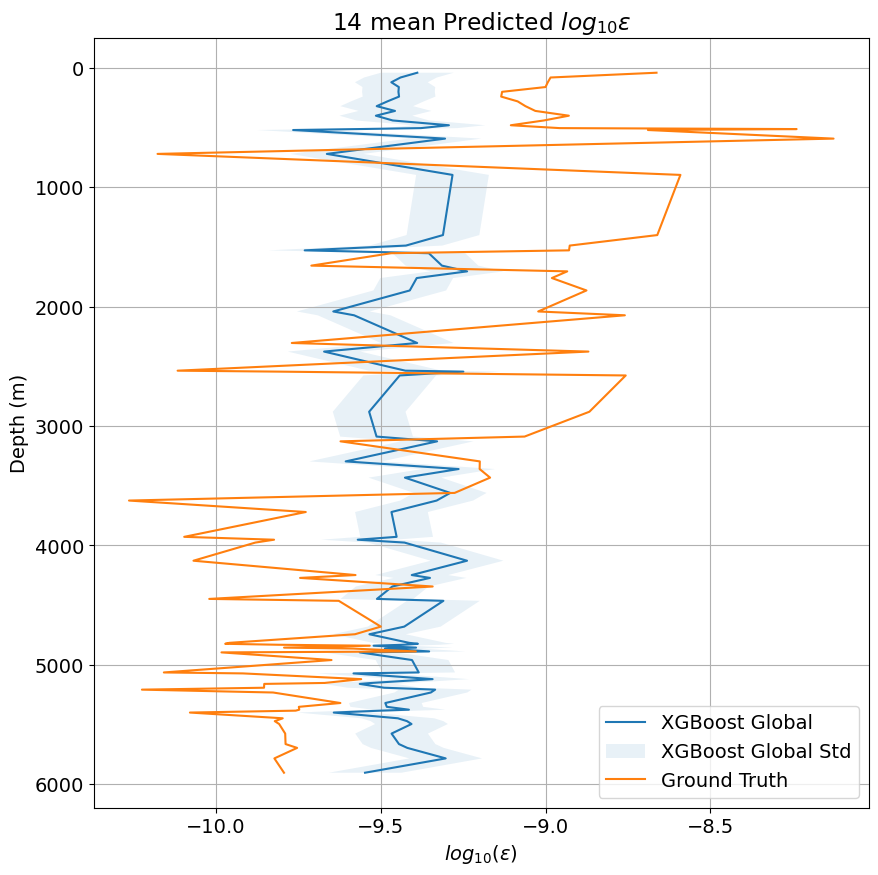

In [29]:
plot_predictions(14, parent_dir)

## Mosaic

In [56]:

def plot_predictions(cruise, parent_dir):
    """
    Plots the mean predicted epsilon values along with the ground truth
    epsilon values for different models (Random Forest, XGBoost, and XGBoost
    7 features) as a function of depth.

    Parameters:
        cruise (str): The name of the cruise.
        parent_dir (str): The parent directory where the pickle files are located.

    Returns:
        None

    Example:
        plot_predictions("cruise1", "/path/to/parent_dir")
    """
    # Specify the path and filename for the pickle file
    cruise_file = cruise + "_testdf.pkl"
    #pickle_path_RF = os.path.join(parent_dir, "models/RandomForest", cruise_file)
    #RF_testdf = pd.read_pickle(pickle_path_RF)

    # Specify the path and filename for the pickle file
    pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost", cruise_file)
    XGB_testdf = pd.read_pickle(pickle_path_XGB)

    # Specify the path and filename for the pickle file
    pickle_path_XGB_g = os.path.join(parent_dir, "models/XGBoost_global", cruise_file)
    XGB_g_testdf = pd.read_pickle(pickle_path_XGB_g)

    sorted_df_XGB = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB = sorted_df_XGB[sorted_df_XGB['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB = sampled_df_XGB.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB = mean_df_XGB['eps_pred'].std()
    ci_lower_XGB = mean_df_XGB['eps_pred'] - std_dev_XGB  # Lower bound of the confidence interval
    ci_upper_XGB = mean_df_XGB['eps_pred'] + std_dev_XGB  # Upper bound of the confidence interval

    sorted_df_XGB_g = XGB_g_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB_g = sorted_df_XGB_g[sorted_df_XGB_g['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB_g = sampled_df_XGB_g.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB_g = mean_df_XGB_g['eps_pred'].std()
    ci_lower_XGB_g = mean_df_XGB_g['eps_pred'] - std_dev_XGB_g  # Lower bound of the confidence interval
    ci_upper_XGB_g = mean_df_XGB_g['eps_pred'] + std_dev_XGB_g  # Upper bound of the confidence interval
    
    #sorted_df_RF = RF_testdf.sort_values('depth')
    # Sample every 10 meters
    #sampled_df_RF = sorted_df_RF[sorted_df_RF['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of epsilon predictions
    #mean_df_RF = sampled_df_RF.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation
    #std_dev_RF = mean_df_RF['eps_pred'].std()
    ##ci_upper_RF = mean_df_RF['eps_pred'] + std_dev_RF  # Upper bound of the confidence interval
    
    sorted_df_GT = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_GT = sorted_df_GT[sorted_df_GT['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_GT = sampled_df_GT.groupby('depth')['log_eps'].mean().reset_index()
    
    #plt.plot(mean_df_RF['eps_pred'], mean_df_RF['depth'], label='RandomForest')
    #plt.fill_betweenx(mean_df_RF['depth'], ci_lower_RF, ci_upper_RF, alpha=0.1, label='Random Forest Std')

    plt.plot(mean_df_XGB_g['eps_pred'], mean_df_XGB_g['depth'], label='XGBoost Global')
    plt.fill_betweenx(mean_df_XGB_g['depth'], ci_lower_XGB_g, ci_upper_XGB_g, alpha=0.1, label='XGBoost Global Std')

    plt.plot(mean_df_XGB['eps_pred'], mean_df_XGB['depth'], label='XGBoost Arctic')
    plt.fill_betweenx(mean_df_XGB['depth'], ci_lower_XGB, ci_upper_XGB, alpha=0.1, label='XGBoost Arctic')
    
    plt.plot(mean_df_GT['log_eps'], mean_df_GT['depth'], label='Ground Truth')

    plt.xlabel('$log_{10}(\epsilon)$')
    plt.ylabel('Depth (m)')
    plt.title(cruise + ' mean Predicted $log_{10} \epsilon$')
    plt.grid(True)
    plt.legend()

    plt.gca().invert_yaxis()  # Invert the y-axis

    plt.show()


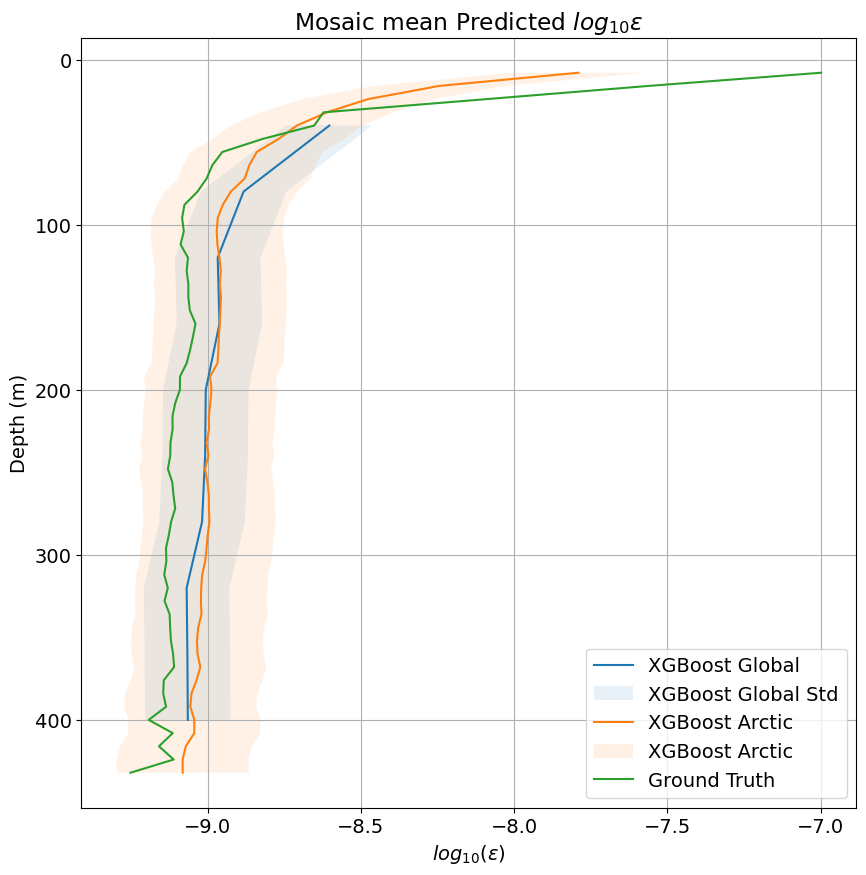

In [57]:
plot_predictions("Mosaic", parent_dir)